In [1]:
import pandas as pd
from pyhive import presto
import getpass
import auth
import psycopg2 as pg
import pandas.io.sql as psql
import pandas_profiling
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import pandas as pd
from pyhive import presto
import getpass
import auth
import psycopg2 as pg
import pandas.io.sql as psql
import pandas_profiling
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
%matplotlib inline
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.gam.tests.test_penalized import df_autos
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:75% !important; }</style>"))

### data explorations

In [5]:
## read dataset
df = pd.read_csv('dataset_for_analyst_assignment_20201120.csv')
df

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE
0,2019-09-01 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
1,2019-09-01 00:00:00.000,FIN,1,1.0,0.0,2020-09-02 00:00:00.000,2020-09-02 00:00:00.000,2,0.0,1.0,0.0,0.0,0.0,38.456,1.0,38.532,38.608,38.456,android,0.0,0.0,1.0,NaN,False,23.0,2.0,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
2,2019-09-01 00:00:00.000,DNK,19,19.0,0.0,2019-12-10 00:00:00.000,2020-05-25 00:00:00.000,3,0.0,4.0,1.0,14.0,0.0,631.488,9.0,20.280,43.688,33.396,android,0.0,19.0,0.0,NaN,True,21.0,2.0,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9..."
3,2019-09-01 00:00:00.000,FIN,0,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
4,2019-09-01 00:00:00.000,GRC,0,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21978,2019-09-30 00:00:00.000,GRC,1,1.0,0.0,2020-01-23 00:00:00.000,2020-01-23 00:00:00.000,21979,0.0,0.0,1.0,0.0,0.0,26.312,1.0,26.364,26.416,26.312,android,0.0,0.0,1.0,NaN,False,12.0,2.0,NaN,NaN,1.383,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
21979,2019-09-30 00:00:00.000,GRC,0,NaN,NaN,NaN,NaN,21980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
21980,2019-09-30 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,21981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
21981,2019-09-30 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,21982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."


In [6]:
df.count()

REGISTRATION_DATE                          21983
REGISTRATION_COUNTRY                       21983
PURCHASE_COUNT                             21983
PURCHASE_COUNT_DELIVERY                    12028
PURCHASE_COUNT_TAKEAWAY                    12028
FIRST_PURCHASE_DAY                         11964
LAST_PURCHASE_DAY                          12027
USER_ID                                    21983
BREAKFAST_PURCHASES                        12028
LUNCH_PURCHASES                            12028
EVENING_PURCHASES                          12028
DINNER_PURCHASES                           12028
LATE_NIGHT_PURCHASES                       12028
TOTAL_PURCHASES_EUR                        12028
DISTINCT_PURCHASE_VENUE_COUNT              12028
MIN_PURCHASE_VALUE_EUR                     12028
MAX_PURCHASE_VALUE_EUR                     12028
AVG_PURCHASE_VALUE_EUR                     12028
PREFERRED_DEVICE                           21910
IOS_PURCHASES                              12028
WEB_PURCHASES       

In [7]:
df.dtypes

REGISTRATION_DATE                           object
REGISTRATION_COUNTRY                        object
PURCHASE_COUNT                               int64
PURCHASE_COUNT_DELIVERY                    float64
PURCHASE_COUNT_TAKEAWAY                    float64
FIRST_PURCHASE_DAY                          object
LAST_PURCHASE_DAY                           object
USER_ID                                      int64
BREAKFAST_PURCHASES                        float64
LUNCH_PURCHASES                            float64
EVENING_PURCHASES                          float64
DINNER_PURCHASES                           float64
LATE_NIGHT_PURCHASES                       float64
TOTAL_PURCHASES_EUR                        float64
DISTINCT_PURCHASE_VENUE_COUNT              float64
MIN_PURCHASE_VALUE_EUR                     float64
MAX_PURCHASE_VALUE_EUR                     float64
AVG_PURCHASE_VALUE_EUR                     float64
PREFERRED_DEVICE                            object
IOS_PURCHASES                  

In [8]:
##extract store column into 5 diff columns
df['General_merchandise'] = df['PURCHASE_COUNT_BY_STORE_TYPE'].str.split('\n').str.get(1).str.split(': ').str[1].str.split(',').str[0].astype(int)
df['Grocery'] = df['PURCHASE_COUNT_BY_STORE_TYPE'].str.split('\n').str.get(2).str.split(': ').str[1].str.split(',').str[0].astype(int)
df['Pet_supplies'] = df['PURCHASE_COUNT_BY_STORE_TYPE'].str.split('\n').str.get(3).str.split(': ').str[1].str.split(',').str[0].astype(int)
df['Restaurant'] = df['PURCHASE_COUNT_BY_STORE_TYPE'].str.split('\n').str.get(4).str.split(': ').str[1].str.split(',').str[0].astype(int)
df['Retail_store'] = df['PURCHASE_COUNT_BY_STORE_TYPE'].str.split('\n').str.get(5).str.split(': ').str[1].str.split(',').str[0].astype(int)

In [9]:
## check if summations match
print(sum(df['PURCHASE_COUNT']))
print(df['PURCHASE_COUNT_DELIVERY'].sum() + df['PURCHASE_COUNT_TAKEAWAY'].sum())
print(df['General_merchandise'].sum() + df['Grocery'].sum() + df['Pet_supplies'].sum() + df['Restaurant'].sum() + df['Retail_store'].sum())

73541
73541.0
73541


In [10]:
## convert time values to datetime in the data
df['REGISTRATION_DATE'] = pd.to_datetime(df['REGISTRATION_DATE'])
df['LAST_PURCHASE_DAY'] = pd.to_datetime(df['LAST_PURCHASE_DAY'])
df['FIRST_PURCHASE_DAY'] = pd.to_datetime(df['FIRST_PURCHASE_DAY'])

In [11]:
## focus is on 3 countries
df['REGISTRATION_COUNTRY'].value_counts()

FIN    10277
DNK     8081
GRC     3042
USA       70
GBR       54
SWE       45
EST       44
DEU       39
NOR       34
ITA       24
POL       23
LTU       22
ESP       19
CZE       14
AUS       11
BEL       11
FRA       11
HUN       11
NLD       10
ISR        9
RUS        8
BRA        7
IRL        7
CYP        7
IND        7
LVA        7
ARE        6
JPN        6
CAN        6
QAT        6
PRT        5
HRV        5
ROU        5
AUT        5
SGP        4
CHE        4
CHN        3
SVK        3
FRO        3
COL        2
ISL        2
AZE        2
UKR        2
LBN        2
TUR        2
JOR        2
CHL        2
KWT        1
SAU        1
HKG        1
PHL        1
KOR        1
GEO        1
SVN        1
GIN        1
TWN        1
PAK        1
MEX        1
MLT        1
Name: REGISTRATION_COUNTRY, dtype: int64

In [12]:
## financials per country for any customers who made at least 1 order
financial = df[df['PURCHASE_COUNT']>0].groupby('REGISTRATION_COUNTRY').agg({'PURCHASE_COUNT':'sum',
                                                               'TOTAL_PURCHASES_EUR':'sum',
                                                               'USER_ID':'count'}).reset_index().sort_values(by = 'TOTAL_PURCHASES_EUR', ascending=False)
total = financial.apply(np.sum)
total['REGISTRATION_COUNTRY'] = 'Total'
financial = financial.append(pd.DataFrame(total.values, index=total.keys()).T, ignore_index=True)
financial['revenue_per_purchase'] = financial['TOTAL_PURCHASES_EUR'] / financial['PURCHASE_COUNT']
financial['revenue_per_user'] = financial['TOTAL_PURCHASES_EUR'] / financial['USER_ID']
financial['purchase_per_user'] = financial['PURCHASE_COUNT'] / financial['USER_ID']
financial.round(1)

,REGISTRATION_COUNTRY,PURCHASE_COUNT,TOTAL_PURCHASES_EUR,USER_ID,revenue_per_purchase,revenue_per_user,purchase_per_user
0,DNK,28222,1028537.092,4985,36.444515,206.326398,5.661384
1,FIN,34634,933584.168,5451,26.955713,171.268422,6.353697
2,GRC,10380,150036.084,1532,14.454343,97.934781,6.775457
3,EST,85,2062.456,13,24.264188,158.650462,6.538462
4,CZE,46,1133.44,4,24.64,283.36,11.5
5,NOR,29,1023.132,13,35.280414,78.702462,2.230769
6,LVA,41,974.556,3,23.769659,324.852,13.666667
7,ISR,16,372.416,3,23.276,124.138667,5.333333
8,LTU,24,327.888,2,13.662,163.944,12.0
9,GBR,17,302.588,2,17.799294,151.294,8.5


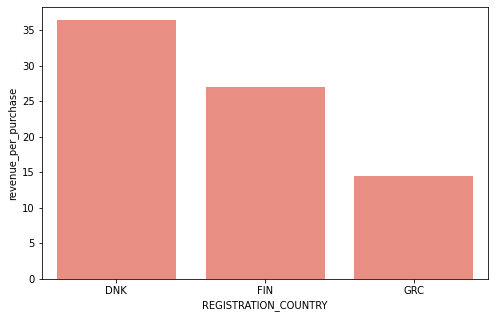

In [13]:
plt.figure(figsize = (8,5))
ax1 = sns.barplot(data = financial[financial['REGISTRATION_COUNTRY'].isin(['DNK','FIN','GRC'])], x = 'REGISTRATION_COUNTRY', y = 'revenue_per_purchase', color="Salmon")


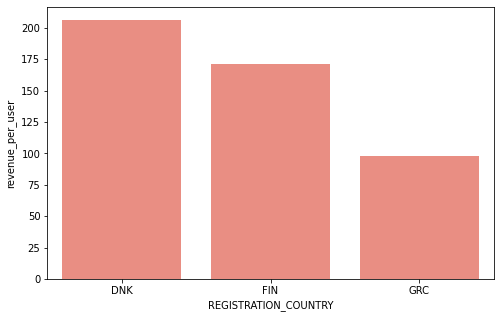

In [14]:
plt.figure(figsize = (8,5))
ax1 = sns.barplot(data = financial[financial['REGISTRATION_COUNTRY'].isin(['DNK','FIN','GRC'])], x = 'REGISTRATION_COUNTRY', y = 'revenue_per_user', color="Salmon")

In [15]:
## takeaway vs delivery shares per country
df2 = df.groupby('REGISTRATION_COUNTRY')[['PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY']].sum().reset_index().sort_values(by = 'PURCHASE_COUNT_DELIVERY', ascending=False)
df2['delivery_share'] = df2['PURCHASE_COUNT_DELIVERY'] / (df2['PURCHASE_COUNT_DELIVERY'] + df2['PURCHASE_COUNT_TAKEAWAY'])
df2[df2['delivery_share'].notnull()]

,REGISTRATION_COUNTRY,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,delivery_share
17,FIN,32569.0,2065.0,0.940377
14,DNK,25996.0,2226.0,0.921125
23,GRC,10218.0,162.0,0.984393
16,EST,82.0,3.0,0.964706
12,CZE,44.0,2.0,0.956522
38,LVA,39.0,2.0,0.951220
37,LTU,24.0,0.0,1.000000
20,GBR,17.0,0.0,1.000000
42,NOR,15.0,14.0,0.517241
30,ISR,13.0,3.0,0.812500


In [16]:
## share of meal types
df3 = df.groupby('REGISTRATION_COUNTRY')[['BREAKFAST_PURCHASES', 'LUNCH_PURCHASES','EVENING_PURCHASES', 'DINNER_PURCHASES','LATE_NIGHT_PURCHASES']].sum()\
.reset_index()
df3 = df3[df3['REGISTRATION_COUNTRY'].isin(['DNK','FIN','GRC'])]
df3[['BREAKFAST_PURCHASES', 'LUNCH_PURCHASES','EVENING_PURCHASES', 'DINNER_PURCHASES','LATE_NIGHT_PURCHASES']] = \
df3[['BREAKFAST_PURCHASES', 'LUNCH_PURCHASES','EVENING_PURCHASES', 'DINNER_PURCHASES','LATE_NIGHT_PURCHASES']].apply(lambda x: x/x.sum(), axis=1)
df3

,REGISTRATION_COUNTRY,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES
14,DNK,0.011592,0.289163,0.028785,0.670460,0.0
17,FIN,0.036720,0.462336,0.076548,0.424396,0.0
23,GRC,0.071104,0.422270,0.236916,0.269711,0.0


In [17]:
## create another dataframe with 3 countries
main = df[df['REGISTRATION_COUNTRY'].isin(['DNK','FIN','GRC'])]

In [18]:
## share of all users per device
df4 = main.groupby(['REGISTRATION_COUNTRY','PREFERRED_DEVICE'])['USER_ID'].count().unstack()
df4.apply(lambda x: x/x.sum(), axis=1)


PREFERRED_DEVICE,android,ios,web
REGISTRATION_COUNTRY,,,
DNK,0.191935,0.557444,0.250620
FIN,0.488481,0.379930,0.131589
GRC,0.547823,0.344987,0.107190


In [19]:
## share of users given at least 1 order per device --- web slightly has the biggest retention on customers than ios and android
main = df[df['REGISTRATION_COUNTRY'].isin(['DNK','FIN','GRC'])]
no_order = main[main['PURCHASE_COUNT']>1].groupby(['REGISTRATION_COUNTRY','PREFERRED_DEVICE'])['USER_ID'].count().unstack()
no_order = no_order.assign(total=no_order.sum(1)).stack().to_frame('Value')

whole = main.groupby(['REGISTRATION_COUNTRY','PREFERRED_DEVICE'])['USER_ID'].count().unstack()
whole = whole.assign(total=whole.sum(1)).stack().to_frame('Value')

no_order/whole

Value
REGISTRATION_COUNTRY PREFERRED_DEVICE          
DNK                  android           0.341306
                     ios               0.394169
                     web               0.478218
                     total             0.405087
FIN                  android           0.332534
                     ios               0.346865
                     web               0.421365
                     total             0.349668
GRC                  android           0.286574
                     ios               0.348948
                     web               0.360000
                     total             0.315963

In [20]:
## share of purchases by store type -- majority is Restaurant ~60%, Retail_stores~20, Grocery :17%
df5 = df.groupby('REGISTRATION_COUNTRY')[['General_merchandise', 'Grocery','Pet_supplies', 'Restaurant','Retail_store']].sum()\
.reset_index()
df5 = df5[df5['REGISTRATION_COUNTRY'].isin(['DNK','FIN','GRC'])]
df5[['General_merchandise', 'Grocery','Pet_supplies', 'Restaurant','Retail_store']] = \
df5[['General_merchandise', 'Grocery','Pet_supplies', 'Restaurant','Retail_store']].apply(lambda x: x/x.sum(), axis=1)
df5

df5.style.format({
    'General_merchandise': '{:,.2%}'.format,
    'Grocery': '{:,.2%}'.format,
    'Pet_supplies': '{:,.2%}'.format,
    'Restaurant': '{:,.2%}'.format,
    'Retail_store': '{:,.2%}'.format
})

,REGISTRATION_COUNTRY,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
14,DNK,2.09%,16.59%,0.22%,62.12%,18.99%
17,FIN,1.98%,17.86%,0.24%,60.01%,19.91%
23,GRC,1.54%,17.17%,0.27%,59.56%,21.46%


### churn problem

In [21]:
df.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
0,2019-09-01,DNK,0,NaN,NaN,NaT,NaT,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0
1,2019-09-01,FIN,1,1.0,0.0,2020-09-02,2020-09-02,2,0.0,1.0,0.0,0.0,0.0,38.456,1.0,38.532,38.608,38.456,android,0.0,0.0,1.0,NaN,False,23.0,2.0,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,1,0
2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,4.0,1.0,14.0,0.0,631.488,9.0,20.280,43.688,33.396,android,0.0,19.0,0.0,NaN,True,21.0,2.0,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9...",1,9,0,9,0
3,2019-09-01,FIN,0,NaN,NaN,NaT,NaT,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0
4,2019-09-01,GRC,0,NaN,NaN,NaT,NaT,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0


In [22]:
## customer waterfall over a year
temp = df
temp['First_purchase_year'] = df['FIRST_PURCHASE_DAY'].dt.year
temp['First_purchase_month'] = df['FIRST_PURCHASE_DAY'].dt.month
temp['Last_purchase_year'] = df['LAST_PURCHASE_DAY'].dt.year
temp['Last_purchase_month'] = df['LAST_PURCHASE_DAY'].dt.month


temp1 =temp.groupby(['First_purchase_year','First_purchase_month'])['USER_ID'].count().reset_index()
temp2 = temp.groupby(['Last_purchase_year','Last_purchase_month'])['USER_ID'].count().reset_index()
temp1['churns'] = temp2['USER_ID']
temp1 = temp1.rename(columns = {'USER_ID' :'acquisitions'})

temp1['active_cust_end_month'] = temp1['acquisitions'] - temp1['churns']
temp1 = temp1.assign(active_cust_end_month=temp1['active_cust_end_month'].cumsum())

temp1['churn_rate'] = temp1['churns'] / temp1['active_cust_end_month'].shift(1)
temp1['YEARMONTH'] = temp1['First_purchase_year'].astype(int).astype(str) + '-' + temp1['First_purchase_month'].astype(int).astype(str)
temp1 = temp1[['YEARMONTH', 'acquisitions', 'churns', 'active_cust_end_month', 'churn_rate']]
temp1

,YEARMONTH,acquisitions,churns,active_cust_end_month,churn_rate
0,2019-9,7135,2767,4368,NaN
1,2019-10,927,555,4740,0.127060
2,2019-11,556,405,4891,0.085443
3,2019-12,361,372,4880,0.076058
4,2020-1,340,312,4908,0.063934
5,2020-2,406,383,4931,0.078036
6,2020-3,330,386,4875,0.078280
7,2020-4,398,438,4835,0.089846
8,2020-5,359,596,4598,0.123268
9,2020-6,243,503,4338,0.109395


Text(0.5, 1.0, 'Active customers vs churn rate')

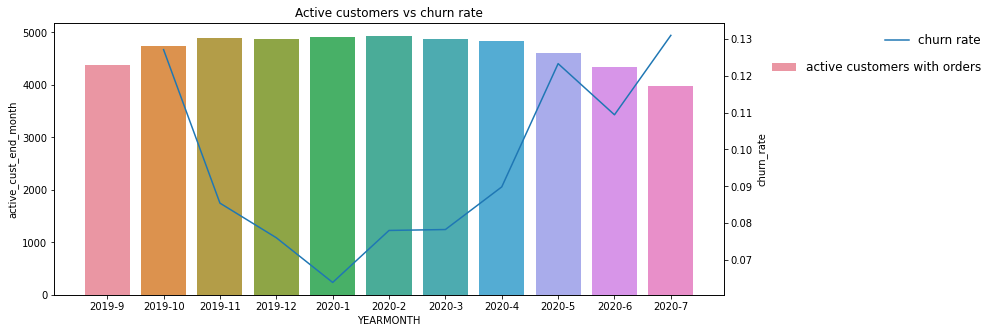

In [23]:
plt.figure(figsize = (12,5))
ax1 = sns.barplot(data = temp1.iloc[:11], x = 'YEARMONTH', y ='active_cust_end_month', label = 'active customers with orders' )
ax1.legend( frameon=False, fontsize = 'large', loc='upper right', bbox_to_anchor=(0.5, 0., 0.9, 0.9))
ax2 = ax1.twinx()
ax2 = sns.lineplot(data = temp1.iloc[:11], x = 'YEARMONTH', y ='churn_rate', legend = True, label = 'churn rate')
ax2.legend(loc='upper right', frameon=False, fontsize = 'large', bbox_to_anchor=(0.5, 0., 0.9, 1))
plt.title('Active customers vs churn rate')

### typical purchase frequency 

In [24]:
main = df[df['REGISTRATION_COUNTRY'].isin(['DNK','FIN','GRC'])]

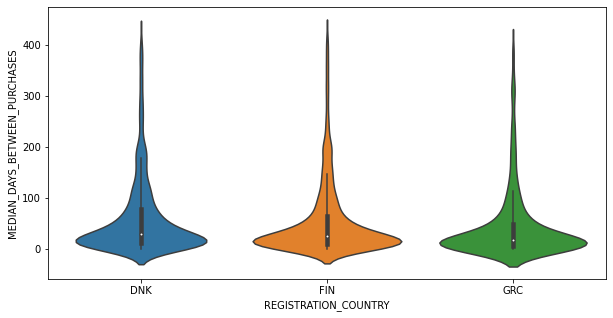

In [25]:
plt.figure(figsize = (10,5))
ax= sns.violinplot(data = main[main['PURCHASE_COUNT']>1], y = 'MEDIAN_DAYS_BETWEEN_PURCHASES', x = 'REGISTRATION_COUNTRY')

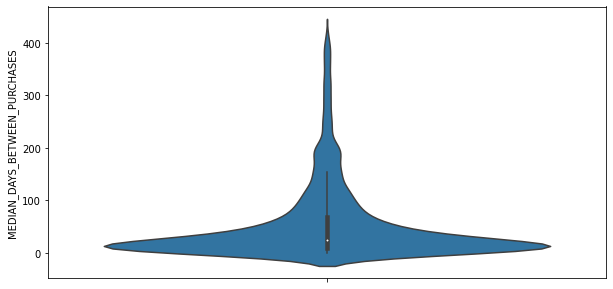

In [26]:
plt.figure(figsize = (10,5))
ax= sns.violinplot(data = df[df['PURCHASE_COUNT']>1], y = 'MEDIAN_DAYS_BETWEEN_PURCHASES')

<Figure size 720x360 with 0 Axes>

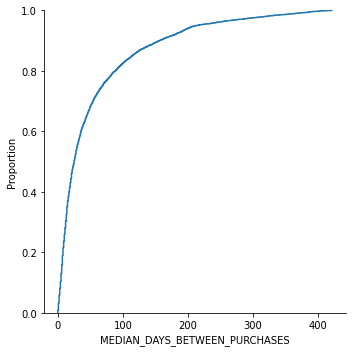

In [27]:
plt.figure(figsize = (10,5))
ax= sns.displot(data = df[df['PURCHASE_COUNT']>1], x = 'MEDIAN_DAYS_BETWEEN_PURCHASES', kind = 'ecdf')

<Figure size 720x360 with 0 Axes>

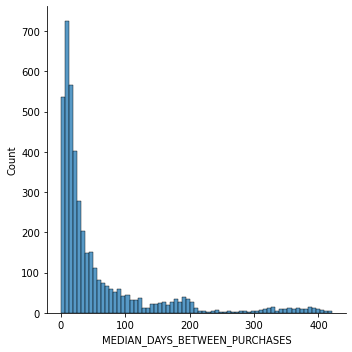

In [28]:
## last 3 months active
plt.figure(figsize = (10,5))
active = df[df['LAST_PURCHASE_DAY'] >= '2020-08-01']
ax= sns.displot(data = active, x = 'MEDIAN_DAYS_BETWEEN_PURCHASES', kind = 'hist')

(0.0, 100.0)

<Figure size 720x360 with 0 Axes>

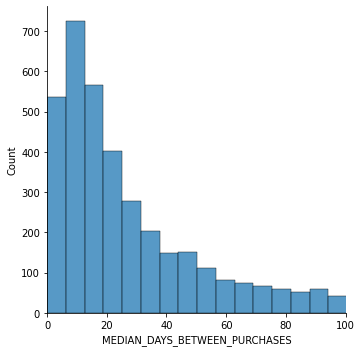

In [29]:
plt.figure(figsize = (10,5))
active = df[df['LAST_PURCHASE_DAY'] >= '2020-08-01']
ax= sns.displot(data = active, x = 'MEDIAN_DAYS_BETWEEN_PURCHASES', kind = 'hist')
plt.xlim(0,100)

### Segment 1: active customers

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'purchase intervals for active customers by last purchase month')

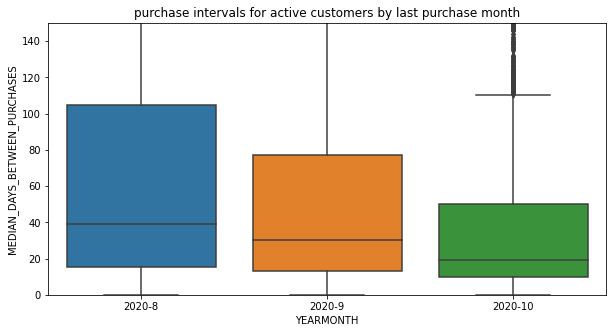

In [30]:
active = df[df['LAST_PURCHASE_DAY'] >= '2020-08-01']
active['YEARMONTH'] = active['Last_purchase_year'].astype(int).astype(str) + '-' + active['Last_purchase_month'].astype(int).astype(str)
plt.figure(figsize = (10,5))
ax= sns.boxplot(data = active, y = 'MEDIAN_DAYS_BETWEEN_PURCHASES', x = 'YEARMONTH', order = ['2020-8', '2020-9', '2020-10'])
ax.set_ylim(0,150)
plt.title('purchase intervals for active customers by last purchase month')

In [31]:
active.shape

(4742, 40)

In [32]:
active.groupby('YEARMONTH')['MEDIAN_DAYS_BETWEEN_PURCHASES'].mean()

YEARMONTH
2020-10    48.182945
2020-8     77.273994
2020-9     68.135983
Name: MEDIAN_DAYS_BETWEEN_PURCHASES, dtype: float64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(0.0, 100.0)

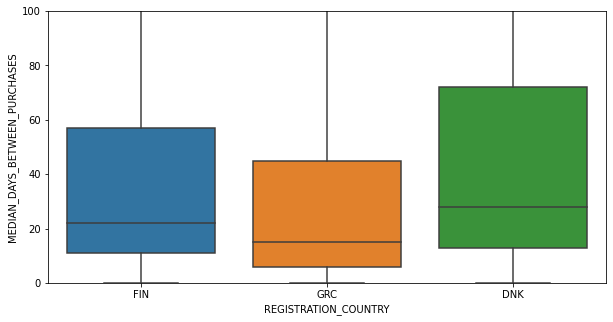

In [33]:
active['YEARMONTH'] = active['Last_purchase_year'].astype(int).astype(str) + '-' + active['Last_purchase_month'].astype(int).astype(str)
plt.figure(figsize = (10,5))
ax= sns.boxplot(data = active[active['REGISTRATION_COUNTRY'].isin(['DNK','FIN','GRC'])], y = 'MEDIAN_DAYS_BETWEEN_PURCHASES', x = 'REGISTRATION_COUNTRY')
ax.set_ylim(0,100)

In [34]:
## active customer whose last order passed median purchased interval
active['time_passed_after_last_purchase'] = (pd.to_datetime('2020-10-31') - active['LAST_PURCHASE_DAY']).dt.days
active[active['time_passed_after_last_purchase'] > active['MEDIAN_DAYS_BETWEEN_PURCHASES']]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store,First_purchase_year,First_purchase_month,Last_purchase_year,Last_purchase_month,YEARMONTH,time_passed_after_last_purchase
13,2019-09-01,FIN,2,2.0,0.0,2020-08-21,2020-09-09,14,0.0,1.0,1.0,0.0,0.0,118.404,1.0,57.798,60.960,59.708,ios,0.0,0.0,2.0,"[\n ""american""\n]",False,5.0,6.0,19.0,19.0,1.382,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,2,0,2020.0,8.0,2020.0,9.0,2020-9,52
42,2019-09-01,GRC,2,2.0,0.0,2020-09-11,2020-09-18,43,0.0,2.0,0.0,0.0,0.0,12.144,2.0,6.084,6.096,6.072,android,2.0,0.0,0.0,NaN,False,12.0,2.0,7.0,7.0,0.271,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,2,0,2020.0,9.0,2020.0,9.0,2020-9,43
69,2019-09-01,GRC,16,16.0,0.0,2020-02-27,2020-10-26,70,0.0,11.0,0.0,5.0,0.0,322.828,7.0,6.084,35.560,20.240,ios,16.0,0.0,0.0,NaN,True,18.0,2.0,16.0,4.0,4.940,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,8,8,2020.0,2.0,2020.0,10.0,2020-10,5
78,2019-09-01,FIN,3,3.0,0.0,2020-09-04,2020-09-20,79,0.0,2.0,0.0,1.0,0.0,74.888,3.0,21.294,32.512,25.300,android,0.0,0.0,3.0,NaN,False,16.0,2.0,8.0,8.0,8.265,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,3,0,2020.0,9.0,2020.0,9.0,2020-9,41
101,2019-09-01,DNK,11,10.0,1.0,2020-05-22,2020-10-15,102,0.0,8.0,0.0,3.0,0.0,269.192,6.0,17.238,51.816,24.288,ios,11.0,0.0,0.0,NaN,False,20.0,3.0,15.0,11.0,1.909,"{\n ""General merchandise"": 1,\n ""Grocery"": 5...",1,5,0,5,0,2020.0,5.0,2020.0,10.0,2020-10,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21918,2019-09-30,DNK,15,15.0,0.0,2019-09-30,2020-10-02,21919,0.0,3.0,4.0,8.0,0.0,306.636,6.0,15.210,30.480,20.240,ios,15.0,0.0,0.0,NaN,False,22.0,4.0,26.0,5.0,9.004,"{\n ""General merchandise"": 1,\n ""Grocery"": 7...",1,7,0,7,0,2019.0,9.0,2020.0,10.0,2020-10,29
21929,2019-09-30,DNK,25,25.0,0.0,2019-10-07,2020-10-18,21930,0.0,9.0,2.0,14.0,0.0,819.720,10.0,15.210,74.168,32.384,ios,25.0,0.0,0.0,"[\n ""chinese""\n]",False,16.0,4.0,16.0,12.0,7.875,"{\n ""General merchandise"": 1,\n ""Grocery"": 1...",1,12,0,12,0,2019.0,10.0,2020.0,10.0,2020-10,13
21933,2019-09-30,GRC,3,3.0,0.0,2020-09-08,2020-09-17,21934,0.0,0.0,1.0,2.0,0.0,38.456,2.0,8.112,19.304,13.156,ios,3.0,0.0,0.0,NaN,True,5.0,5.0,5.0,5.0,3.033,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,3,0,2020.0,9.0,2020.0,9.0,2020-9,44
21964,2019-09-30,GRC,25,25.0,0.0,2019-10-09,2020-10-14,21965,7.0,12.0,0.0,6.0,0.0,377.476,5.0,10.140,26.416,15.180,android,0.0,0.0,25.0,NaN,True,5.0,3.0,15.0,11.0,9.141,"{\n ""General merchandise"": 1,\n ""Grocery"": 1...",1,12,0,12,0,2019.0,10.0,2020.0,10.0,2020-10,17


In [35]:
## financials per country for any customers made at least 1 order
financial = active[active['PURCHASE_COUNT']>0].groupby('REGISTRATION_COUNTRY').agg({'PURCHASE_COUNT':'sum',
                                                               'TOTAL_PURCHASES_EUR':'sum',
                                                               'USER_ID':'count'}).reset_index().sort_values(by = 'TOTAL_PURCHASES_EUR', ascending=False)
total = financial.apply(np.sum)
total['REGISTRATION_COUNTRY'] = 'Total'
financial = financial.append(pd.DataFrame(total.values, index=total.keys()).T, ignore_index=True)
financial['revenue_per_purchase'] = financial['TOTAL_PURCHASES_EUR'] / financial['PURCHASE_COUNT']
financial['revenue_per_user'] = financial['TOTAL_PURCHASES_EUR'] / financial['USER_ID']
financial['purchase_per_user'] = financial['PURCHASE_COUNT'] / financial['USER_ID']
financial.round(1)

,REGISTRATION_COUNTRY,PURCHASE_COUNT,TOTAL_PURCHASES_EUR,USER_ID,revenue_per_purchase,revenue_per_user,purchase_per_user
0,DNK,19236,689692.168,1884,35.85424,366.078645,10.210191
1,FIN,25154,673456.652,2231,26.773342,301.863134,11.274765
2,GRC,6860,102275.756,595,14.909002,171.892027,11.529412
3,EST,69,1721.412,7,24.948,245.916,9.857143
4,LVA,39,855.14,2,21.926667,427.57,19.5
5,CZE,35,831.864,1,23.767543,831.864,35.0
6,NOR,19,616.308,7,32.437263,88.044,2.714286
7,ISR,13,272.228,2,20.940615,136.114,6.5
8,HUN,8,206.448,3,25.806,68.816,2.666667
9,SWE,5,162.932,3,32.5864,54.310667,1.666667


### Common/distinctive characteristics of each segment

In [36]:
##FINAL SEGMENTATION TO BE USED
df['customer_status'] = np.where(df['LAST_PURCHASE_DAY'] >= '2020-08-01', 'active', np.where(df['PURCHASE_COUNT'] ==0,'first_time_buyer', 'deactive'))
df

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store,First_purchase_year,First_purchase_month,Last_purchase_year,Last_purchase_month,customer_status
0,2019-09-01,DNK,0,NaN,NaN,NaT,NaT,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0,NaN,NaN,NaN,NaN,first_time_buyer
1,2019-09-01,FIN,1,1.0,0.0,2020-09-02,2020-09-02,2,0.0,1.0,0.0,0.0,0.0,38.456,1.0,38.532,38.608,38.456,android,0.0,0.0,1.0,NaN,False,23.0,2.0,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,1,0,2020.0,9.0,2020.0,9.0,active
2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,4.0,1.0,14.0,0.0,631.488,9.0,20.280,43.688,33.396,android,0.0,19.0,0.0,NaN,True,21.0,2.0,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9...",1,9,0,9,0,2019.0,12.0,2020.0,5.0,deactive
3,2019-09-01,FIN,0,NaN,NaN,NaT,NaT,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0,NaN,NaN,NaN,NaN,first_time_buyer
4,2019-09-01,GRC,0,NaN,NaN,NaT,NaT,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0,NaN,NaN,NaN,NaN,first_time_buyer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21978,2019-09-30,GRC,1,1.0,0.0,2020-01-23,2020-01-23,21979,0.0,0.0,1.0,0.0,0.0,26.312,1.0,26.364,26.416,26.312,android,0.0,0.0,1.0,NaN,False,12.0,2.0,NaN,NaN,1.383,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,1,0,2020.0,1.0,2020.0,1.0,deactive
21979,2019-09-30,GRC,0,NaN,NaN,NaT,NaT,21980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0,NaN,NaN,NaN,NaN,first_time_buyer
21980,2019-09-30,DNK,0,NaN,NaN,NaT,NaT,21981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0,NaN,NaN,NaN,NaN,first_time_buyer
21981,2019-09-30,DNK,0,NaN,NaN,NaT,NaT,21982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0,NaN,NaN,NaN,NaN,first_time_buyer


In [37]:
df['customer_status'].value_counts()

first_time_buyer    9955
deactive            7286
active              4742
Name: customer_status, dtype: int64

In [38]:
df[df['REGISTRATION_COUNTRY'].isin(['DNK', 'FIN', 'GRC'])].groupby(['REGISTRATION_COUNTRY', 'customer_status'])['USER_ID'].count().unstack().apply(lambda x: x/x.sum(), axis=1)

customer_status,active,deactive,first_time_buyer
REGISTRATION_COUNTRY,,,
DNK,0.233139,0.383740,0.383121
FIN,0.217087,0.313321,0.469592
GRC,0.195595,0.308021,0.496384


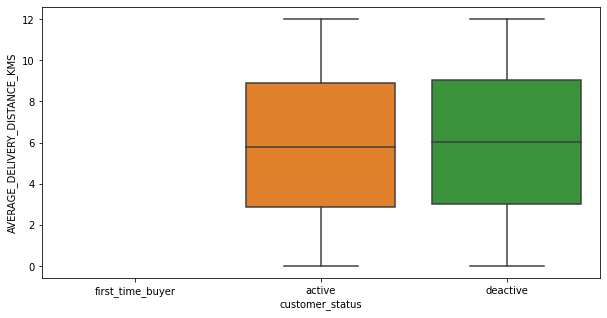

In [39]:
## avg delivery distance do not differ in between active and deactive customers
plt.figure(figsize = (10,5))
ax= sns.boxplot(data = df, y = 'AVERAGE_DELIVERY_DISTANCE_KMS', x = 'customer_status')


(0.0, 50.0)

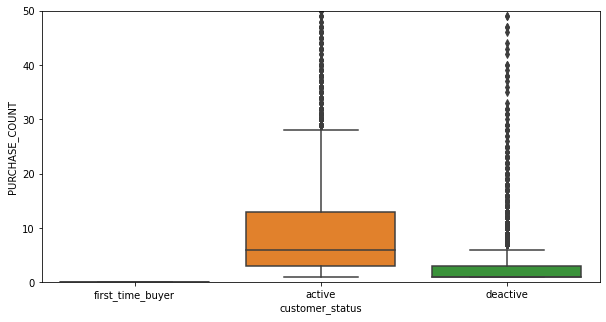

In [40]:
## purchase count>3 goes to the active bucket
plt.figure(figsize = (10,5))
ax= sns.boxplot(data = df, y = 'PURCHASE_COUNT', x = 'customer_status')
ax.set_ylim(0,50)

In [41]:
df[df['customer_status']=='deactive']['PURCHASE_COUNT'].describe()

count    7286.000000
mean        3.030332
std         6.371267
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       320.000000
Name: PURCHASE_COUNT, dtype: float64

In [42]:
##repetitive restaurant orders are more likely in active customers
df['repetitive'] = df['PURCHASE_COUNT'] / df['DISTINCT_PURCHASE_VENUE_COUNT']
df[df['PURCHASE_COUNT']>1].groupby('customer_status')['repetitive'].mean()

customer_status
active      2.087015
deactive    1.676691
Name: repetitive, dtype: float64

Text(0.5, 1.0, 'repetitive definition')

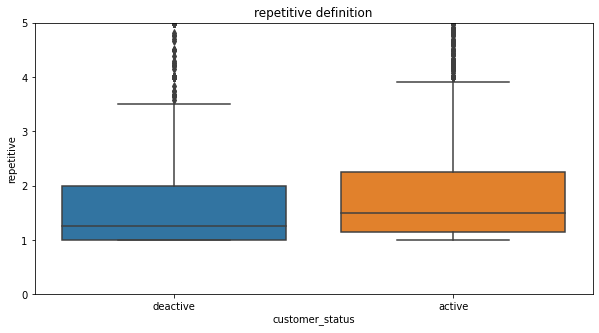

In [43]:
plt.figure(figsize = (10,5))
ax= sns.boxplot(data = df[df['PURCHASE_COUNT']>1], y = 'repetitive', x = 'customer_status')
ax.set_ylim(0,5)
plt.title('repetitive definition')

In [44]:
## top 5 restaurant types could also be used to drive sales
df[df['customer_status']=='deactive']['PREFERRED_RESTAURANT_TYPES'].value_counts().head(10)

[\n  "american"\n]                                285
[\n  "japanese"\n]                                175
[\n  "italian"\n]                                 169
[\n  "mexican"\n]                                 100
[\n  "indian"\n]                                   68
[\n  "american",\n  "italian"\n]                   41
[\n  "middle eastern"\n]                           22
[\n  "american",\n  "italian",\n  "mexican"\n]     16
[\n  "korean"\n]                                   14
[\n  "vietnamese"\n]                               13
Name: PREFERRED_RESTAURANT_TYPES, dtype: int64